In [1]:
import os
import time
from datetime import datetime
import numpy as np
#import matplotlib.pyplot as plt
from collections import deque
import gym
import pandas as pd
from pathlib import Path
import sys
import random
import tensorflow as tf
from sqlalchemy import create_engine

from environments import PortfolioEnvironment, PortfolioEnvironmentTargetReward
from utils import ReplayBufferMultiObs
from policies import TD3

In [2]:
def reshape_dict_state(state):
    obs = {}
    for key,value in state.items():
        obs[key] = np.array([value])
    return obs

In [3]:
engine = create_engine(f'mysql+pymysql://{os.environ["MYSQL_USER"]}:{os.environ["MYSQL_PASSWORD"]}@{os.environ["MYSQL_SERVER"]}:{os.environ["MYSQL_PORT"]}/tfm')

In [4]:
seed = 0
load_model = True
start_timesteps = 1e4 if not load_model else 1e3 # Number of timesteps in which the model choose a random action, after that number starts using the policy
save_freq = 5e3
max_timesteps = 7e5 
expl_noise = 0.05 # Exploration noise 
batch_size = 100 
discount = 0.97 # reward Discount factor gamma 
tau = 0.005 # target weights update ratio
policy_noise = 0.0 # std deviation of gaussian noise to be added to the action, for exploration purposes
noise_clip = 0.4 # max value of gaussian noise added to action
policy_freq = 2 # actor model weights update frecuency


In [5]:
model_path = './models/21_05_2022_11_48_02' 
max_steps = 200
fee = 0.25/100
window = 50

In [6]:
tickers = "('AAPL','AMZN','BA','COIN','FB','GM','GOLD','GOOG','JNJ','JPM','KO','MSFT','NKE','NVDA','PFE','SPY','SQ','TSLA','V','WMT','XOM')"

In [7]:
#tickers = ['AAPL','AMZN','GM','GOLD','JPM','MSFT','NVDA','KO','TSLA','V','XOM','WMT']
assets_data_list = []
assets_data_list_test = []
tickers = {v: k for k, v in engine.execute(f"SELECT id,ticker FROM tickers where ticker in {tickers} order by id asc").fetchall()}
for t in tickers.keys():
    #assets_data_list.append(pd.read_csv(f'./data/{t}.csv'))
    assets_data_list.append(pd.read_sql(f"SELECT close,high,low from historical_hour inner join tickers on ticker_id = tickers.id where ticker = '{t}' order by time asc",engine))
    assets_data_list_test.append(assets_data_list[-1].tail(max_steps+window))
    assets_data_list[-1] = assets_data_list[-1].iloc[:assets_data_list[-1].shape[0]-max_steps,]

target = pd.read_sql("select close from historical_hour inner join tickers on ticker_id = tickers.id where ticker = 'SPY' order by time asc",engine)

Por algun motivo cuando agrego otro feature que tiene el indice, hay mejores resultados
Cosas por probar: seguir entrenando, con diferentes expl_noise, cambiar la funcion softmax de activacion por una custom q no tome los exponentes, reentrenar usando el modelo en ./models/03_05_2022_13_35_56 , se entreno con datos normalizados, 

cambiar la funcion softmax de activacion por una custom q no tome los exponentes, probar que pasa si no estan normalizados, Se cambiaron ambas cosas hubo mejores resultados, ahora los weights no se mantienen constante aun poniendo la exploracion en cero, el resultado de ese modelo esta en ./models/05_05_2022_09_53_14

Probar nuevamente datos normalizados, en la ultima columna dejar el numero de episodio, pero que vaya siempre desde 1 al ultimo del batch, esto esta en ./models/06_05_2022_17_41_13


funcion reward que tenga en cuenta cuanta guita esta haciendo pero tambien comparar contra un indicador del mercado esto es para lograr que recompense mejor si esta opearndo por encima del mercado, ./models/21_05_2022_11_48_02

tomar acciones de otro tipo de industrias se entreno con portfolio mas variado ./models/17_05_2022_08_29_45 y ./models/19_05_2022_14_23_56 20_05_2022_08_24_18

In [8]:
#env = PortfolioEnvironment(tickers.keys(),assets_data_list,fee=fee,look_back_window=window,max_steps=max_steps)
env = PortfolioEnvironmentTargetReward(tickers.keys(),assets_data_list,target.to_numpy().reshape(1,-1)[0],fee=fee,look_back_window=window,max_steps=max_steps)


In [9]:
state_dim = env.observation_space["data"].shape
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

In [10]:
policy = TD3(state_dim,action_dim,max_action)

replay_buffer = ReplayBufferMultiObs()

In [11]:
if load_model:
    policy.load(model_path)

In [12]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
saved_models_path = f'./models/{datetime.now().strftime("%d_%m_%Y_%H_%M_%S")}'

In [ ]:
start_time=time.time()
info_list = []
while total_timesteps < max_timesteps:
    if done:
        if total_timesteps != 0:
            print(f'Total timesteps: {total_timesteps} Episode Num: {episode_num} Reward: {episode_reward} Portfolio Value:{env.portfolio_value_units}')
            policy.train(replay_buffer,episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)
        
        if timesteps_since_eval >= save_freq:
            timesteps_since_eval %= save_freq
            policy.save(saved_models_path)
            #print(f'Total timesteps: {total_timesteps} Episode Num: {episode_num} Reward: {episode_reward} Portfolio Value:{env.portfolio_value_units}')

        
        obs = env.reset()
        done = False
        
        episode_reward = 0
        episode_timesteps = 0
        episode_num +=1
        
    if total_timesteps < start_timesteps:
        #action = tf.nn.softmax(env.action_space.sample()+ np.random.normal(0,1,size=env.action_space.shape[0])).numpy()
        action = np.clip(np.random.normal(2,3,size=env.action_space.shape[0]),0,None)
        action = action/action.sum()
    else:
        action = policy.select_action(reshape_dict_state(obs))
        #print(action)
        if expl_noise != 0: 
            action = np.clip(action + np.random.normal(0,expl_noise,size=env.action_space.shape[0]),0,None)
            action = action/action.sum()
            #action = tf.nn.softmax((action + np.random.normal(0,expl_noise,size=env.action_space.shape[0]))).numpy()
    
    
    next_obs,reward,done, info = env.step(action)
    info_list.append(info)
    done_bool = 0 if episode_timesteps +1 == env.max_steps else float(done)
    
    
    episode_reward += reward
    replay_buffer.add((obs,next_obs,action,reward,done_bool))
    
    obs = next_obs
    episode_timesteps +=1
    total_timesteps +=1
    timesteps_since_eval +=1


policy.save(saved_models_path)
print(f'Tiempo de entrenamiento: {time.time()-start_time} segundos')

Total timesteps: 200 Episode Num: 1 Reward: -19179.861153477814 Portfolio Value:59311.298057563654
Total timesteps: 400 Episode Num: 2 Reward: -23959.691571693373 Portfolio Value:57357.44134739017


In [13]:
import matplotlib.pyplot as plt
from environments import PortfolioEnvironmentTest

In [15]:
env2 = PortfolioEnvironmentTest(tickers.keys(),assets_data_list_test,fee=fee,look_back_window=window)

#for m in os.listdir('./models'):
policy.load(f'./models/20_05_2022_08_24_18')
state = env2.reset()
done = False
total_reward = 0
infos = []

while not done:
    action = policy.select_action(reshape_dict_state(state))
    state, reward, done, info = env2.step(action)
    #print(reward)
    total_reward += reward
    infos.append(info)
    #print(action)

print(total_reward)

-9806.855350136


In [28]:
p_evolution = [1.0]
for info in infos:
    p_evolution.append(info['value'])
    

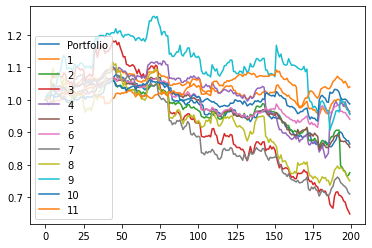

In [35]:
pd.Series(p_evolution).reset_index(drop=True).plot()
for a in assets_data_list_test:
    (a.iloc[50:,0]/a.iloc[50,0]).reset_index(drop=True).plot()
plt.legend(['Portfolio','1','2','3','4','5','6','7','8','9','10','11'],loc=3)

In [27]:
serie

1578    163.65
1579    164.67
1580    164.76
1581    165.38
1582    168.07
         ...  
1773    160.36
1774    160.15
1775    159.95
1776    158.74
1777    157.65
Name: close, Length: 200, dtype: float64

# ------ PRUEBAS---------

In [27]:
max_value = 0
index = 0
for i,v in enumerate(info_list):
    if v['value'] > max_value:
        max_value = v['value']
        index = i
print(max_value)
print(info_list[index])


1.1928068269087038
{'weights': array([0.        , 0.12493297, 0.        , 0.12493297, 0.12493297,
       0.        , 0.12493297, 0.12493297, 0.12493297, 0.00053627,
       0.12493297, 0.12493297], dtype=float32), 'value': 1.1928068269087038, 'position': 940}


In [45]:
info_list[index-173] #+26 es el ultimo

{'weights': array([0.1279268 , 0.1328057 , 0.        , 0.07251303, 0.04147185,
        0.        , 0.05293043, 0.08518989, 0.0713501 , 0.00406993,
        0.07308968, 0.33865255], dtype=float32),
 'value': 0.9978198170743418,
 'position': 767}

In [46]:
#pos 249
weights = []
for d in info_list[index-173:index+27]:
    weights.append(d['weights'])
weights = np.array(weights)
weights.shape

(200, 12)

In [51]:
weights[3]

array([2.29485458e-10, 1.21506825e-01, 0.00000000e+00, 1.21506825e-01,
       1.21506825e-01, 0.00000000e+00, 1.21506825e-01, 1.21506825e-01,
       1.21506825e-01, 2.79453751e-02, 1.21506825e-01, 1.21506825e-01],
      dtype=float32)

In [47]:
data = env.buffer.data
data = data[:,50:250,1].T
data = np.concatenate((np.ones(shape=(data.shape[0],1)),data),axis=1)
data

array([[1.00000e+00, 1.27780e+02, 3.20927e+03, ..., 6.45960e+02,
        2.26920e+02, 5.98600e+01],
       [1.00000e+00, 1.27860e+02, 3.21878e+03, ..., 6.45240e+02,
        2.26860e+02, 5.99200e+01],
       [1.00000e+00, 1.27720e+02, 3.22276e+03, ..., 6.38120e+02,
        2.25840e+02, 6.00200e+01],
       ...,
       [1.00000e+00, 1.30440e+02, 3.50097e+03, ..., 6.24820e+02,
        2.30520e+02, 5.89100e+01],
       [1.00000e+00, 1.30270e+02, 3.49281e+03, ..., 6.25000e+02,
        2.30720e+02, 5.86100e+01],
       [1.00000e+00, 1.30400e+02, 3.49101e+03, ..., 6.22430e+02,
        2.30380e+02, 5.86400e+01]])

In [49]:
data.shape

(200, 12)

In [66]:
portfolio_value = []
valor = 100000
for i in range(1,data.shape[0]):
    valor = (weights[i-1]*valor/data[i-1]*data[i]).sum()
    portfolio_value.append(valor)

<AxesSubplot:>

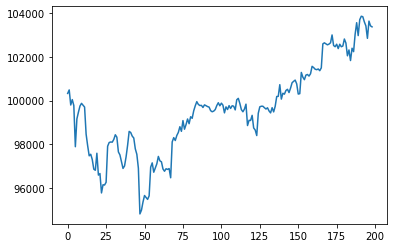

In [73]:
pd.Series(portfolio_value).plot()